# Jupyter Example for HERMES

In [1]:
import sys
sys.path.append('/home/tospines/Hermes/build/')
from pyhermes import *
from pyhermes.units import *

import astropy.units as u

import numpy as np
import healpy

import astropy.io.fits as pyfits

import matplotlib.pyplot as plt
from matplotlib import rc, rcParams
import matplotlib.ticker as tick
import matplotlib.colors as colors
from matplotlib import cm
from healpy.newvisufunc import projview, newprojplot

###############
# LaTeX block #
###############

rc('text', usetex=True)
rc('font',**{'family':'serif','serif':['Palatino']})
rc('xtick', labelsize=18)
rc('ytick', labelsize=18)
rcParams['legend.numpoints'] = 1

### Adjusting the input parameters for our model

In [2]:
nside = 8
sun_pos = Vector3QLength(8.*kpc, 0*pc, 0*pc)

In [3]:
DragonRuns = '/home/tospines/Hermes/DragonRuns/'
filename = DragonRuns + "Basemodel.fits.gz"

dragon2D_proton = cosmicrays.Dragon2D(filename, [Proton])
dragon2D_helium = cosmicrays.Dragon2D(filename, [Helium])
cr_list = [dragon2D_proton, dragon2D_helium]

XCOvalues = [1.8, 1.8, 1.8, 3.5, 3.5, 3.5, 3.5, 7., 7., 7., 7., 7.]
#Correspond to the bins: {0_kpc, 0.86_kpc, 2_kpc, 3_kpc,  4_kpc,  5_kpc, 6_kpc, 7_kpc, 9_kpc, 12_kpc, 15_kpc, 18_kpc}

neutral_gas_HI = neutralgas.RingModel(neutralgas.GasType.HI)
neutral_gas_H2 = neutralgas.RingModel(neutralgas.GasType.H2, XCOvalues)

kelner_crossections = interactions.KelnerAharonianGamma()
#kamae_crosssection = interactions.Kamae06Gamma()

hermes: info: reading species with Z = 1 A = 1 at HDU = 6
hermes: info: reading species with Z = 1 A = 1 at HDU = 7
hermes: info: reading species with Z = 2 A = 4 at HDU = 11
Number of rings: 12
Number of rings: 12


In [4]:
integratorHI = PiZeroIntegrator(cr_list, neutral_gas_HI, kelner_crossections)
integratorH2 = PiZeroIntegrator(cr_list, neutral_gas_H2, kelner_crossections)

integratorHI.setupCacheTable(60, 60, 24) # nx,ny,nz
integratorHI.setObsPosition(sun_pos)
integratorH2.setupCacheTable(60, 60, 24)
integratorH2.setObsPosition(sun_pos)

In [5]:
print("building SkyMapRange object for pi0")
skymapHI_range = GammaSkymapRange(nside, 0.1*GeV, 10.*TeV, 40)
skymapH2_range = GammaSkymapRange(nside, 0.1*GeV, 10.*TeV, 40)

mask_edges = ([-90.*deg, 90.*deg], [360.*deg, 0*deg])
mask = RectangularWindow(*mask_edges)

skymapHI_range.setMask(mask)
skymapH2_range.setMask(mask)

building SkyMapRange object for pi0


In [ ]:
print("starting calculation of skymaps... ")

# Calculation of HI skymap
skymapHI_range.setIntegrator(integratorHI)
skymapHI_range.compute()
nameHI = "Test_BaseRunHI_nside{}".format(nside)
skymapHI_range.save(outputs.HEALPixFormat("!{}.fits.gz".format(nameHI)))
print("pi0 HI done")

# Calculation of H2 skymap
skymapH2_range.setIntegrator(integratorH2)
skymapH2_range.compute()
nameH2 = "Test_BaseRunH2_nside{}".format(nside)
skymapH2_range.save(outputs.HEALPixFormat("!{}.fits.gz".format(nameH2)))
print("pi0 H2 done")

### Extracting the maps

In [6]:
# Defining the energy of reference for our maps
reference_energy = 10.*GeV
energy_vector = np.asarray([s.getEnergy() for s in skymapHI_range])
index = np.argmin(np.abs(energy_vector - reference_energy))
print("We are considering the map at E = ", energy_vector[index]/GeV)

We are considering the map at E =  11.25335582600766


In [7]:
# Defining the units to use in our maps
use_units = "GeV^-1 cm^-2 s^-1 sr^-1"
skymap_units = u.Quantity(1, use_units)
Hermes_units = u.Quantity(1, "GeV^-1 m^-2 s^-1 sr^-1") # default units for Hermes (GeV^-1 m^-2 s^-1 sr^-1)

base_units = Hermes_units.to(skymap_units)
base_units

<Quantity 1.e-04 1 / (cm2 GeV s sr)>

##### Opening the saved file

In [15]:
Runpath = '/home/tospines/Hermes/Work/HermesRuns/'
H2_hdulist = pyfits.open(Runpath + nameH2 + ".fits.gz")  # = skymapH2_range
header = H2_hdulist[index+1].header
HI_hdulist = pyfits.open(Runpath + nameHI + ".fits.gz")  # = skymapHI_range

nside = header['NSIDE']
npix = healpy.nside2npix(nside)


In [17]:
# Extracting fluxes and energy vector from our previous runs:
HI_map = np.array(skymapHI_range[index])*base_units
H2_map = np.array(skymapH2_range[index])*base_units
E_pi = energy_vector/GeV

# Extracting fluxes and energy vector from a different previous run:
#GeV_units = 1/(1.6021766339999998e-10)  # From Joules to GeV
#SI_units = 1.e4 # From flux in m^-2 to cm^-2
#HI_map, H2_map, E_pi = [], [], []
#for iE in range(len(HI_hdulist))[1:]:
#        HI_map.append(HI_hdulist[iE].data.astype(float)/SI_units)
#        H2_map.append(H2_hdulist[iE].data.astype(float)/SI_units)
#        E_pi.append(HI_hdulist[iE].header['ENERGY']*GeV_units)

In [8]:
Runpath = '/home/tospines/Hermes/Work/HermesRuns/'
H2_hdulist = pyfits.open(Runpath + "BaseMax-Abs_H2_nside64.fits.gz")  #"BaseRunH2_nside64.fits.gz")
HI_hdulist = pyfits.open(Runpath + "BaseMax-Abs_HI_nside64.fits.gz")  #"BaseRunHI_nside64.fits.gz")

index=4

nside = H2_hdulist[1].header['NSIDE']
npix = healpy.nside2npix(nside)

GeV_units = 1/(1.6021766339999998e-10)  # From Joules to GeV
SI_units = 1. #1.e4 # From flux in m^-2 to cm^-2
HI_map, H2_map, E_pi = [], [], []
for iE in range(len(HI_hdulist))[1:]:
        HI_map.append(HI_hdulist[iE].data.astype(float)/SI_units)
        H2_map.append(H2_hdulist[iE].data.astype(float)/SI_units)
        E_pi.append(HI_hdulist[iE].header['ENERGY']*GeV_units)

### Displaying the maps

/tmp/ipykernel_362/2017894427.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().yaxis.set_ticklabels(["", "150", "100", "50", "0", "-50", "-100", "-150"])
/tmp/ipykernel_362/2017894427.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().xaxis.set_ticklabels(["", "75", "50", "25", "0", "-25", "-50", "-75"])


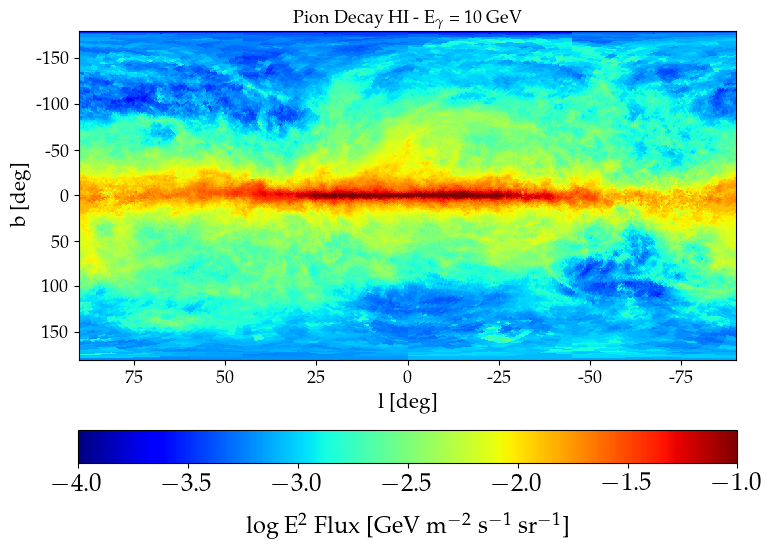

In [9]:
Cartmap = projview(np.log10(np.maximum(HI_map[index], 1e-20)*(E_pi[index]**2)), coord=["G"], graticule=True, 
    graticule_labels=True, cmap='jet', projection_type="cart", latitude_grid_spacing=25, longitude_grid_spacing=50,
    cbar = False, fontsize={"xlabel": 15, "ylabel": 15, "xtick_label": 13, "ytick_label": 13, "title": 13},
     title=r'Pion Decay HI - E$_{\gamma}$ = 10 GeV',  xlabel="l [deg]", ylabel="b [deg]", 
    unit= "log E$^2$ Flux [GeV m$^{-2}$ s$^{-1}$ sr$^{-1}$]", min=-4, max=-1);  

plt.gca().yaxis.set_ticklabels(["", "150", "100", "50", "0", "-50", "-100", "-150"])
plt.gca().xaxis.set_ticklabels(["", "75", "50", "25", "0", "-25", "-50", "-75"])
plt.grid(visible=False)

cbar = plt.colorbar(Cartmap, orientation="horizontal", shrink=0.78) 
cbar.ax.get_xaxis().labelpad = 10
cbar.ax.set_xlabel("log E$^2$ Flux [GeV m$^{-2}$ s$^{-1}$ sr$^{-1}$]", rotation=0, fontsize = 17)

plt.tight_layout()
#plt.savefig("Cartmap_HI.png", dpi=250)    

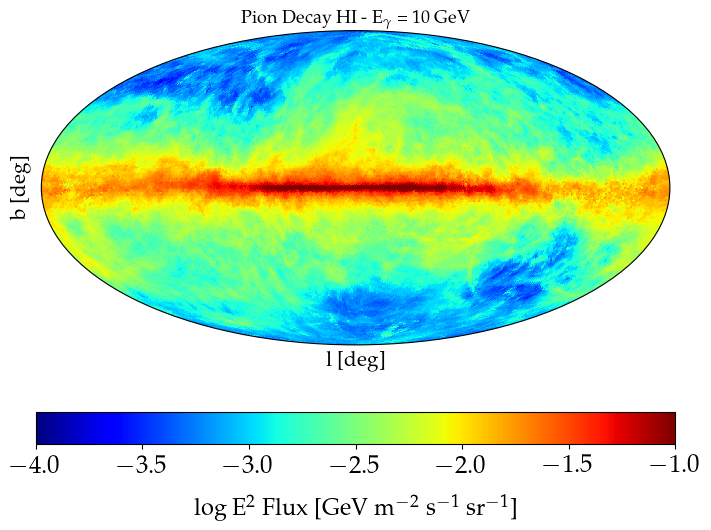

In [45]:
Cartmap = projview(np.log10(np.maximum(HI_map[index], 1e-20)*(E_pi[index]**2)), coord=["G"], graticule=True, 
    graticule_labels=False, cmap='jet', projection_type="mollweide", latitude_grid_spacing=25, longitude_grid_spacing=50,
    cbar = False, fontsize={"xlabel": 15, "ylabel": 15, "xtick_label": 13, "ytick_label": 13, "title": 13},
     title=r'Pion Decay HI - E$_{\gamma}$ = 10 GeV',  xlabel="l [deg]", ylabel="b [deg]", min=-4, max=-1); 

plt.grid(visible=False)

cbar = plt.colorbar(Cartmap, orientation="horizontal", shrink=0.78) 
cbar.ax.get_xaxis().labelpad = 10
cbar.ax.set_xlabel("log E$^2$ Flux [GeV m$^{-2}$ s$^{-1}$ sr$^{-1}$]", rotation=0, fontsize = 17)

plt.tight_layout()
#plt.savefig("Mollmap_HI.png", dpi=250)    

/tmp/ipykernel_8983/2765768645.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().yaxis.set_ticklabels(["", "150", "100", "50", "0", "-50", "-100", "-150"])
/tmp/ipykernel_8983/2765768645.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().xaxis.set_ticklabels(["", "75", "50", "25", "0", "-25", "-50", "-75"])


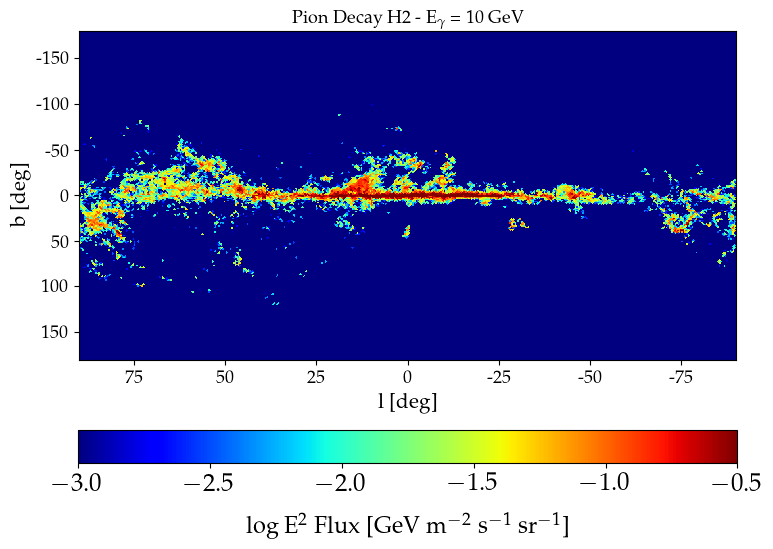

In [46]:
Cartmap = projview(np.log10(np.maximum(H2_map[index], 1e-20)*(E_pi[index]**2)), coord=["G"], graticule=True, 
    graticule_labels=True, cmap='jet', projection_type="cart", latitude_grid_spacing=25, longitude_grid_spacing=50,
    cbar = False, fontsize={"xlabel": 15, "ylabel": 15, "xtick_label": 13, "ytick_label": 13, "title": 13},
     title=r'Pion Decay H2 - E$_{\gamma}$ = 10 GeV',  xlabel="l [deg]", ylabel="b [deg]", min=-3, max=-0.5); 

plt.gca().yaxis.set_ticklabels(["", "150", "100", "50", "0", "-50", "-100", "-150"])
plt.gca().xaxis.set_ticklabels(["", "75", "50", "25", "0", "-25", "-50", "-75"])
plt.grid(visible=False)

cbar = plt.colorbar(Cartmap, orientation="horizontal", shrink=0.78) 
cbar.ax.get_xaxis().labelpad = 10
cbar.ax.set_xlabel("log E$^2$ Flux [GeV m$^{-2}$ s$^{-1}$ sr$^{-1}$]", rotation=0, fontsize = 17)

plt.tight_layout()
#plt.savefig("Cartmap_H2.png", dpi=250)    

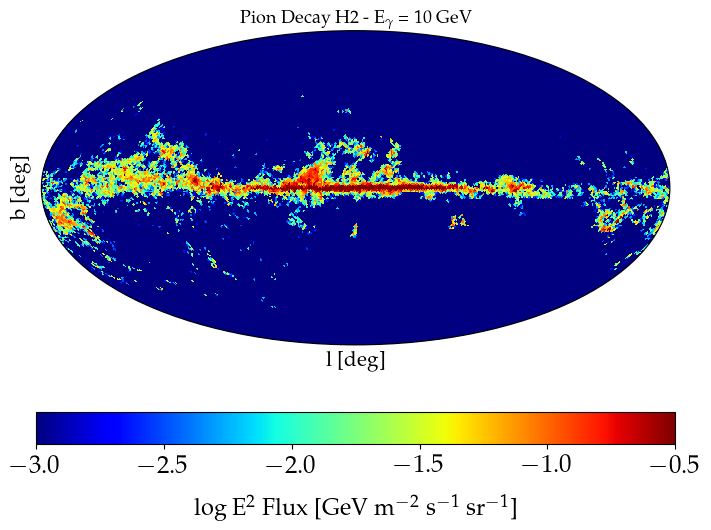

In [47]:
Cartmap = projview(np.log10(np.maximum(H2_map[index], 1e-20)*(E_pi[index]**2)), coord=["G"], graticule=True, 
    graticule_labels=False, cmap='jet', projection_type="mollweide", latitude_grid_spacing=25, longitude_grid_spacing=50,
    cbar = False, fontsize={"xlabel": 15, "ylabel": 15, "xtick_label": 13, "ytick_label": 13, "title": 13},
     title=r'Pion Decay H2 - E$_{\gamma}$ = 10 GeV',  xlabel="l [deg]", ylabel="b [deg]", min=-3, max=-0.5); 

plt.grid(visible=False)

cbar = plt.colorbar(Cartmap, orientation="horizontal", shrink=0.78) 
cbar.ax.get_xaxis().labelpad = 10
cbar.ax.set_xlabel("log E$^2$ Flux [GeV m$^{-2}$ s$^{-1}$ sr$^{-1}$]", rotation=0, fontsize = 17)

plt.tight_layout()
#plt.savefig("Mollmap_H2.png", dpi=250)    